# Time Series Project
 - Forecasting For Monthly ridership Using ARIMA/SARIMA, HOLT-WINTER and LSTM Model

## Name: Parul Joshi
## Reg No.: 21122041

## Objective
 - A comparative studyis performed to forecast the ridership in India for the next five years using ARIMA/SARIMA, Holt-Winter Exponential and LSTM models with the help of accuracy measures. 

## Data Source
 - A time-series approach is used in the monthly ridership data between 1960–1969.

## Analysis with Coding
 - A comparative study is performed in this project. We imported the data, and then we could
see that there existed 114 observations.

In [3]:
!pip install pmdarima


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# Import necessary libraries
import numpy as np
import seaborn as sns

# dataframe opertations - pandas
import pandas as pd

# plotting data - matplotlib
from matplotlib import pyplot as plt

# time series - statsmodels 
# Seasonality decomposition
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.stattools import adfuller
import pmdarima as pm

# SARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# holt winters    
# double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Evaluation Metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from statsmodels.tools.eval_measures import rmse

# Scaling
from sklearn.preprocessing import MinMaxScaler

# LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [20]:
# Loading dataset
df=pd.read_csv("D:/DATASETS/port.csv",  sep=',', parse_dates=['Month'], index_col='Month')
df

,ridership
Month,
1960-01-01,648
1960-02-01,646
1960-03-01,639
1960-04-01,654
1960-05-01,630
...,...
1969-02-01,1425
1969-03-01,1419
1969-04-01,1432


In [21]:
# dimension of the dataset
df.shape

(114, 1)

In [22]:
# statistical information about the dataset
df.describe()

,ridership
count,114.000000
mean,1120.543860
std,270.888317
min,613.000000
25%,885.000000
50%,1158.000000
75%,1340.000000
max,1558.000000


In [23]:
# Checking missing values
df.isnull().sum()

 ridership    0
dtype: int64

#### Normal Time Series Plot

<AxesSubplot:title={'center':'Month Production'}, xlabel='Month'>

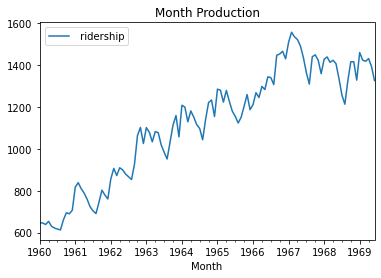

In [24]:
# Time series plot
df.plot(title='Month Ridership')

## Decomposing the Time Series

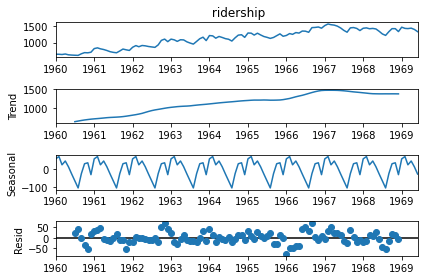

In [29]:
# Additive model
decomposition = seasonal_decompose(df[' ridership'],  model='additive', period=12)
decomposition.plot()
plt.show()

 - The decomposition plot indicates that the monthly ridership has an increasing trend and seasonal pattern.

## ACF and PACF
 - For stationarity check

C:\Users\SUBHAM\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


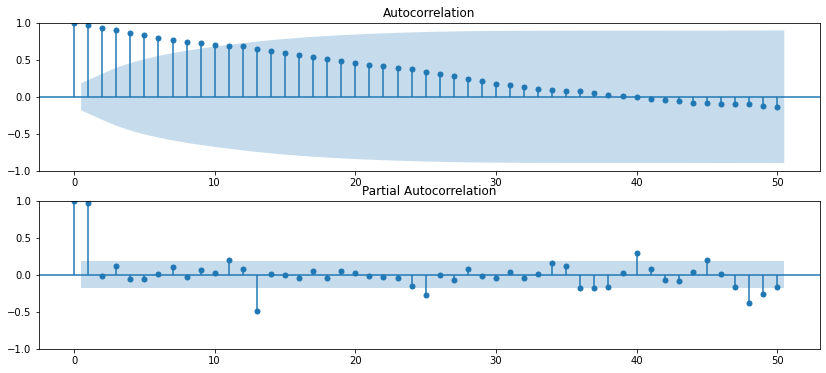

In [27]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,6), sharex=False, sharey=False)
ax1 = plot_acf(df, lags=50, ax=ax1)
ax2 = plot_pacf(df, lags=50, ax=ax2)
plt.savefig('acfpacf2')
plt.show()

- Here we see that both ACF and PACF plots do not show a quick cut off into the 95% confidence interval area (in blue) meaning time series is not stationary.

## Statistical test --- Dickey-Fuler Test
 - For stationarity check

- **Null Hypothesis: The data series is not stationary.**
- **Alternative Hypothesis: The data series is stationary.**

In [30]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df[' ridership'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -1.536597
p-value                          0.515336
#Lags Used                      12.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


- So, we can see p-value(0.515336) grater than 0.05. So we can't reject the null hypothesis. So, we can conclude that the data series is not stationary.

## Making Time Series Data Stationary

In [31]:
df_diff = df.diff().diff(12)

In [32]:
df_diff.dropna(inplace=True)

In [34]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df_diff[' ridership'])

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -9.258520e+00
p-value                        1.427874e-15
#Lags Used                     0.000000e+00
Number of Observations Used    1.000000e+02
Critical Value (1%)           -3.497501e+00
Critical Value (5%)           -2.890906e+00
Critical Value (10%)          -2.582435e+00
dtype: float64


- So, here we can see p-value(1.427874e-15) less than 0.05. So we reject the null hypothesis. So, we can conclude that the data series is stationary.

## ARIMA & SARIMA MODEL
 - ARIMA models are denoted with the order of ARIMA(p,d,q) and SARIMA models are denoted with the order of SARIMA(p, d, q)(P, D, Q)m.

 - AR(p) is a regression model that utilizes the dependent relationship between an observation and some number of lagged observations.

 - I(d) is the differencing order to make time series stationary.

 - MA(q) is a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

 - (P, D, Q)m, these parameters describe the seasonal components of the model. P, D, and Q represent the seasonal regression, differencing, and moving average coefficients, and m represents the number of data points in each seasonal cycle.

## HOLT EXPONENTIAL SMOOTHING
 - Holt's two-parameter model, also known as linear, exponential smoothing, is a popular smoothing model for forecasting data with trends. Holt's model has three separate equations that work together to generate a final forecast. The first is a basic smoothing equation that directly adjusts the last smoothed value for the previous trend. The trend itself is updated over time through the second equation, where the movement is expressed as the difference between the last two smoothed values.

- **If the data has Trend and Seasonal component both, we can use SARIMA & Holt-Winters.**

- **If we remove Seasonality component, we can use ARIMA and Holt's Exponential.**

- **And if we remove Trend & Seasonality both, we can use ARMA & Simple Exponential as the data will be Stationary then.**

- So, in our case the data series is non-stationary. **So, we can use SARIMA & Holt-Winters.**

## Model Parameter Estimation
 - For automatically extracting the best parameters for Seasonal ARIMA model we will use Python’s pmdarima library. Inside auto_arima function, there are d=1 and D=1 beacause of differentiating once for the trend and once for seasonality, m=12 because of monthly data, and trend='c' to include constant and seasonal=True to fit a seasonal-ARIMA. Besides, we specify trace=True for printing status on the fits. This things gives us to find the best parameters by comparing the AIC scores.

In [36]:
# We will use Python’s pmdarima library, to automatically extract the best parameters for our Seasonal ARIMA model. 
model = pm.auto_arima(df[' ridership'],
                      d=1, D=1, m=12, trend='c', seasonal=True, 
                      start_p=0, start_q=0, max_order=6, test='adf',
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.54 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1028.351, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1024.970, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1014.861, Time=0.22 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1029.850, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.39 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=0.62 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1024.969, Time=0.14 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.74 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1013.844, Time=0.09 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.39 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1022.981, Time=0.12 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=0.60 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1015.014, Time=0.20 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1016.6

In [37]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  114
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -503.922
Date:                              Wed, 16 Nov 2022   AIC                           1013.844
Time:                                      20:06:25   BIC                           1021.689
Sample:                                  01-01-1960   HQIC                          1017.020
                                       - 06-01-1969                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.7167      1.328     -1.293      0.196      -4.319       0.886
ma.S.L12      -0.7606      0.123     -6.178      0.000      -1.002      -0.519
sigma2      1140.1007    180.943      6.301      0.000     785.460    1494.742
===================================================================================
Ljung-Box (L1) (Q):                   0.84   Jarque-Bera (JB):                 2.07
Prob(Q):                              0.36   Prob(JB):                         0.36
Heteroskedasticity (H):               1.42   Skew:                             0.31
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- The result of auto_arima function with various parameters indicates that the lowest AIC score is obtained when the parameters equal to (0,1,0)(0,1,1)[12].

#### Splitting Dataset

<AxesSubplot:xlabel='Month'>

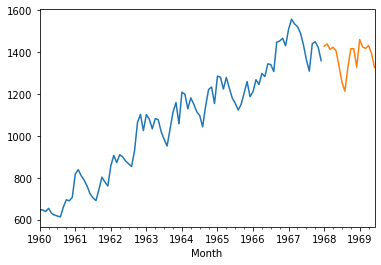

In [38]:
#divide into train and validation set
train = df[:int(0.85*(len(df)))]
test = df[int(0.85*(len(df))):]

#plotting the data
train[' ridership'].plot()
test[' ridership'].plot()

In [75]:
len(test)

18

## SARIMA Model

In [39]:
model = SARIMAX(train[' ridership'],
                order=(1,1,0),seasonal_order=(0,1,1,12))
results = model.fit()
results.summary()

C:\Users\SUBHAM\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\SUBHAM\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            ridership   No. Observations:                   96
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -416.995
Date:                              Wed, 16 Nov 2022   AIC                            839.990
Time:                                      20:06:58   BIC                            847.246
Sample:                                  01-01-1960   HQIC                           842.905
                                       - 12-01-1967                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0244      0.102     -0.239      0.811      -0.224       0.175
ma.S.L12      -0.6168      0.150     -4.106      0.000      -0.911      -0.322
sigma2      1262.7476    211.749      5.963      0.000     847.728    1677.767
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.81
Prob(Q):                              0.92   Prob(JB):                         0.40
Heteroskedasticity (H):               2.09   Skew:                             0.24
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Insample forecast

In [40]:
test_predictions=results.forecast(steps=len(test))
test_predictions

1968-01-01    1442.098560
1968-02-01    1473.594647
1968-03-01    1440.164421
1968-04-01    1464.636394
1968-05-01    1436.914210
1968-06-01    1414.916571
1968-07-01    1377.864337
1968-08-01    1336.591054
1968-09-01    1442.874008
1968-10-01    1474.746560
1968-11-01    1480.392815
1968-12-01    1420.700017
1969-01-01    1502.693675
1969-02-01    1534.192317
1969-03-01    1500.762028
1969-04-01    1525.234003
1969-05-01    1497.511819
1969-06-01    1475.514181
Freq: MS, Name: predicted_mean, dtype: float64

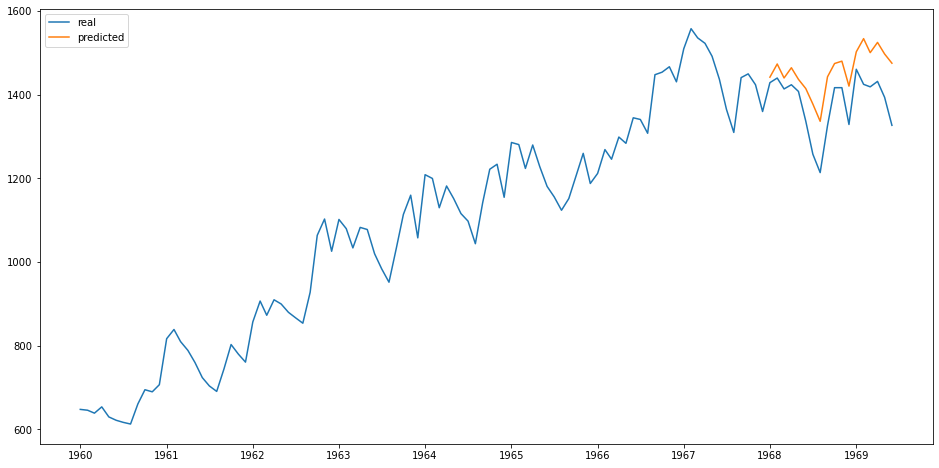

In [41]:
plt.figure(figsize=(16,8))

# Plot actual as line
plt.plot(df[' ridership'].index, df[' ridership'], label='real')

# Plot the prediction as line
plt.plot(test_predictions, label='predicted')

# Plot legend and show figure
plt.legend()
plt.savefig('predtest')
plt.show()

In [42]:
actual = test[' ridership']
data = {'Actual': actual, 'Predicted': test_predictions}
actual_predicted=pd.DataFrame(data)
actual_predicted

,Actual,Predicted
1968-01-01,1429,1442.098560
1968-02-01,1440,1473.594647
1968-03-01,1414,1440.164421
1968-04-01,1424,1464.636394
1968-05-01,1408,1436.914210
1968-06-01,1337,1414.916571
1968-07-01,1258,1377.864337
1968-08-01,1214,1336.591054
1968-09-01,1326,1442.874008
1968-10-01,1417,1474.746560


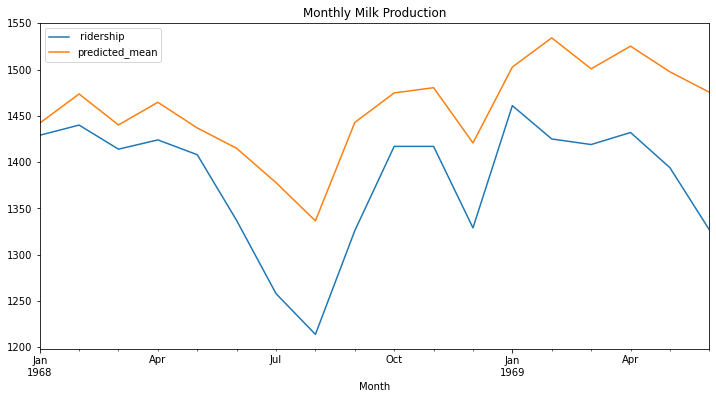

In [43]:
# Plot predictions against known values
title = 'Monthly Ridership'
ax = test[' ridership'].plot(legend=True,figsize=(12,6),title=title)
test_predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)

#### 1. Ljung-Box Test

## For checking Residuals Analysis
 - Residuals are uncorrelated.
 - Residuals are normally ditributed.

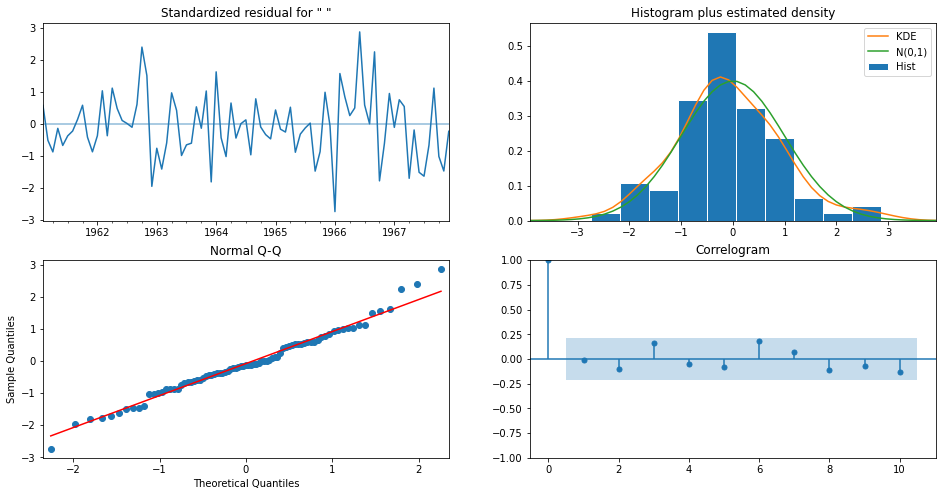

In [44]:
results.plot_diagnostics(figsize=(16, 8))
plt.savefig('modeldiagnostics')
plt.show()

- Standardized residual plot shows the residuals over time and it appears to be a white noise with no seasonal component.
- Histogram with KDE plot shows that kde line (in red) closely follows the N(0,1) line, which is the standard notation of normal distribution with zero mean and standard deviation of 1, suggesting the residuals are normally distributed.
- Normal QQ-plot shows ordered distribution of residuals (in blue) closely follow the linear trend of the samples taken from a standard normal distribution, suggesting residuals are normally distributed.
- Correlogram plot indicating residuals have a low correlation with lagged versions.

## Statitical Test  -- Ljung-Box Test**
   - For checking uncorrelated or not.

- **Null Hypothesis: The data are independently distributed, no autocorrelation.**
- **Alternative Hypothesis: The data are not independently distributed; they exhibit serial correlation.**

In [45]:
# 3. Ljung-Box residual test on our best model => model2 => ARIMA(3,2,2)(0,1,0)[12]
# For determining max. lags for L-B test, we will use folling formulae :
# h = min(10,n/5) --- for non-seasonal TS
# h = min(2m,n/5) --- for seasonal TS
# n = length of time series
# m = seasonal period

# In our case, we have seasonal ts 
n = len(train)
m = 12
h = min(2*m,n/5)
print ('Results of Ljung-Box Test:')
sm.stats.acorr_ljungbox(x = results.resid,lags = [h], return_df = True)

Results of Ljung-Box Test:


,lb_stat,lb_pvalue
19,7.172668,0.993234


- So, we can see p-value(0.993234) greater than 0.05. So we can't reject null hypothesis. So, we can conclude that the data are independently distributed, no autocorrelation means uncorrelated.

- **So, we can tell that suggest residuals for SARIMA model are normally distributed with low correlation.**

#### Evaluation Metrics

In [46]:
evaluation_results = pd.DataFrame({'r2_score': r2_score(test[' ridership'], test_predictions)}, index=['test_sarima'])
evaluation_results['mean_absolute_error'] = mean_absolute_error(test[' ridership'], test_predictions)
evaluation_results['mean_squared_error'] = mean_squared_error(test[' ridership'], test_predictions)
evaluation_results['root_mean_squared_error'] = np.sqrt(mean_squared_error(test[' ridership'], test_predictions))
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(test_predictions - test[' ridership'])/np.abs(test[' ridership']))*100


test_metrics= evaluation_results
test_metrics

,r2_score,mean_absolute_error,mean_squared_error,root_mean_squared_error,mean_absolute_percentage_error
test_sarima,-0.677729,76.133423,7287.274902,85.365537,5.618362


In [47]:
evaluation_results = pd.DataFrame({'r2_score': r2_score(train[' ridership'], results.fittedvalues)}, index=['train_sarima'])
evaluation_results['mean_absolute_error'] = mean_absolute_error(train[' ridership'], results.fittedvalues)
evaluation_results['mean_squared_error'] = mean_squared_error(train[' ridership'], results.fittedvalues)
evaluation_results['root_mean_squared_error'] = np.sqrt(mean_squared_error(train[' ridership'], results.fittedvalues))
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(results.fittedvalues - train[' ridership'])/np.abs(train[' ridership']))*100 

train_metrics = evaluation_results
train_metrics

,r2_score,mean_absolute_error,mean_squared_error,root_mean_squared_error,mean_absolute_percentage_error
train_sarima,0.914187,35.176693,6038.851557,77.710048,3.74101


In [48]:
em1 = pd.concat([test_metrics,train_metrics])
em1

,r2_score,mean_absolute_error,mean_squared_error,root_mean_squared_error,mean_absolute_percentage_error
test_sarima,-0.677729,76.133423,7287.274902,85.365537,5.618362
train_sarima,0.914187,35.176693,6038.851557,77.710048,3.741010


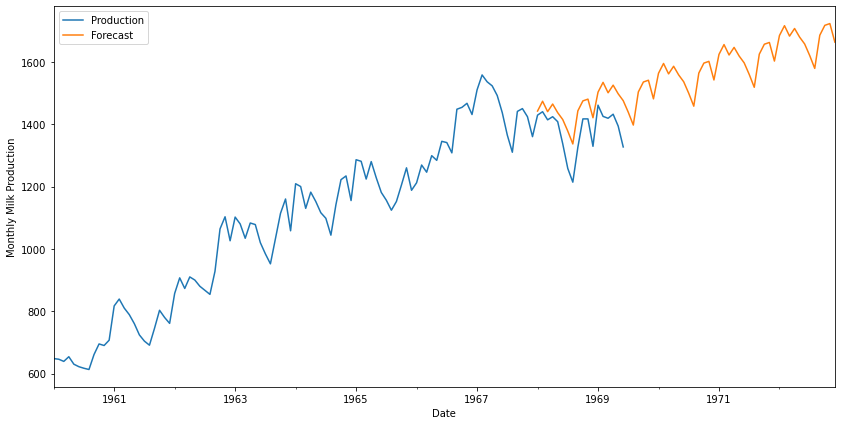

In [49]:
# Outsample forecast
pred_f = results.forecast(steps=60)
ax = df[' ridership'].plot(label='Production', figsize=(14, 7))
pred_f.plot(ax=ax, label='Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Monthly Ridership')
plt.legend()
plt.show()

# Holt-Winter

In [50]:
fitted_model = ExponentialSmoothing(train[' ridership'],trend='add',seasonal='add',seasonal_periods=12).fit()

C:\Users\SUBHAM\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


#### Insample forecast

In [51]:
test_predictions_hw=fitted_model.forecast(steps=len(test))
test_predictions_hw

1968-01-01    1457.095861
1968-02-01    1474.638968
1968-03-01    1438.373962
1968-04-01    1467.119784
1968-05-01    1442.651071
1968-06-01    1417.993356
1968-07-01    1393.391421
1968-08-01    1363.897966
1968-09-01    1445.697029
1968-10-01    1502.715776
1968-11-01    1516.452476
1968-12-01    1462.716923
1969-01-01    1558.452776
1969-02-01    1575.995883
1969-03-01    1539.730877
1969-04-01    1568.476699
1969-05-01    1544.007985
1969-06-01    1519.350270
Freq: MS, dtype: float64

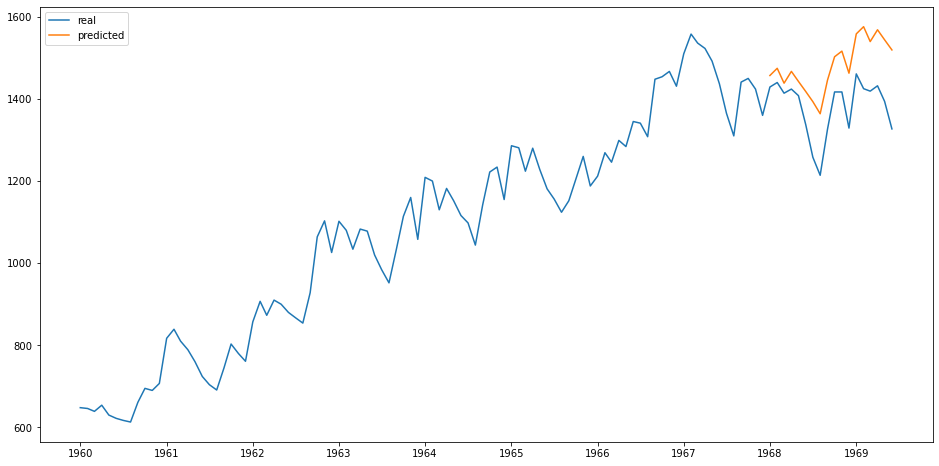

In [52]:
plt.figure(figsize=(16,8))

# Plot past CO2 levels
plt.plot(df[' ridership'].index, df[' ridership'], label='real')

# Plot the prediction means as line
plt.plot(test_predictions_hw, label='predicted')

# Plot legend and show figure
plt.legend()
plt.savefig('predtest')
plt.show()

In [53]:
actual = test[' ridership']
data1 = {'Actual': actual, 'Predicted': test_predictions_hw}
actual_predicted1=pd.DataFrame(data1)
actual_predicted1

,Actual,Predicted
1968-01-01,1429,1457.095861
1968-02-01,1440,1474.638968
1968-03-01,1414,1438.373962
1968-04-01,1424,1467.119784
1968-05-01,1408,1442.651071
1968-06-01,1337,1417.993356
1968-07-01,1258,1393.391421
1968-08-01,1214,1363.897966
1968-09-01,1326,1445.697029
1968-10-01,1417,1502.715776


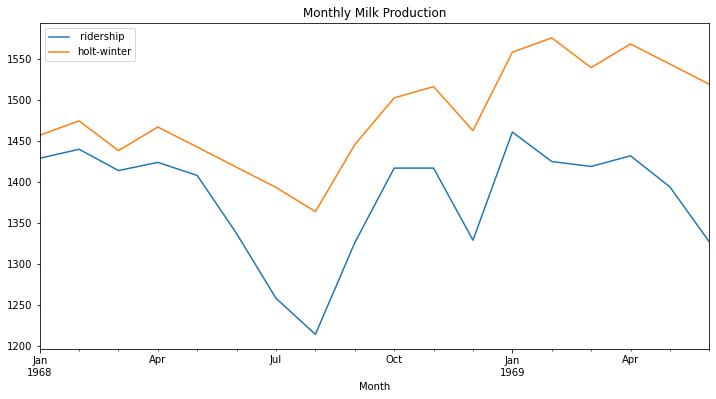

In [54]:
# Plot predictions against known values
title = 'Monthly Ridership'
ax = test[' ridership'].plot(legend=True,figsize=(12,6),title=title)
test_predictions_hw.plot(legend=True,label='holt-winter')
ax.autoscale(axis='x',tight=True)

#### Checking normality of residuals using distribution plot and q-q plot

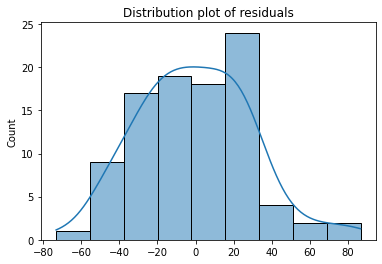

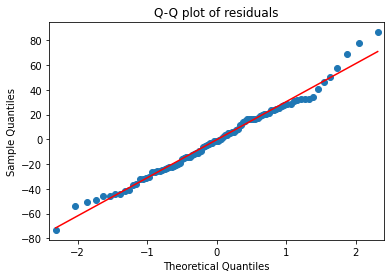

In [55]:
plt.figure()
sns.histplot(fitted_model.resid, kde = True)
plt.title('Distribution plot of residuals')
sm.qqplot(fitted_model.resid, line = 'r')
plt.title('Q-Q plot of residuals')
plt.show()

- Normal QQ-plot and Histogram with KDE plot both shows ordered distribution of residuals closely follow the linear trend of the samples taken from a standard normal distribution, suggesting residuals are normally distributed.

## Statitical Test --- Ljung-Box Test
 - For checking autocorrelation

- **Null Hypothesis: The data are independently distributed, no autocorrelation.**
- **Alternative Hypothesis: The data are not independently distributed; they exhibit serial correlation.**

In [56]:
print ('Results of Ljung-Box Test:')
sm.stats.acorr_ljungbox(fitted_model.resid, lags=[12], return_df=True)

Results of Ljung-Box Test:


,lb_stat,lb_pvalue
12,15.787495,0.201164


- So, we can see p-value(0.201164) greater than 0.05. So we can't reject null hypothesis. So, we can conclude that the data are independently distributed, no autocorrelation means uncorrelated.

- **So, we can tell that suggest residuals for Holt-Winter model are normally distributed with low correlation.**

#### Evaluation Metrics

In [57]:
evaluation_results = pd.DataFrame({'r2_score': r2_score(test[' ridership'], test_predictions_hw)}, index=['test_holt-winter'])
evaluation_results['mean_absolute_error'] = mean_absolute_error(test[' ridership'], test_predictions_hw)
evaluation_results['mean_squared_error'] = mean_squared_error(test[' ridership'], test_predictions_hw)
evaluation_results['root_mean_squared_error'] = np.sqrt(mean_squared_error(test[' ridership'], test_predictions_hw))
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(test_predictions_hw - test[' ridership'])/np.abs(test[' ridership']))*100 


test_metrics1= evaluation_results
test_metrics1


,r2_score,mean_absolute_error,mean_squared_error,root_mean_squared_error,mean_absolute_percentage_error
test_holt-winter,-1.909161,100.986616,12636.041023,112.410146,7.414968


In [58]:
evaluation_results = pd.DataFrame({'r2_score': r2_score(train[' ridership'], fitted_model.fittedvalues)}, index=['train_holt-winter'])
evaluation_results['mean_absolute_error'] = mean_absolute_error(train[' ridership'], fitted_model.fittedvalues)
evaluation_results['mean_squared_error'] = mean_squared_error(train[' ridership'], fitted_model.fittedvalues)
evaluation_results['root_mean_squared_error'] = np.sqrt(mean_squared_error(train[' ridership'], fitted_model.fittedvalues))
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(fitted_model.fittedvalues - train[' ridership'])/np.abs(train[' ridership']))*100 


train_metrics1 = evaluation_results
train_metrics1

,r2_score,mean_absolute_error,mean_squared_error,root_mean_squared_error,mean_absolute_percentage_error
train_holt-winter,0.987424,23.89179,885.000519,29.748958,2.281549


In [59]:
em2 = pd.concat([test_metrics1,train_metrics1])
em2

,r2_score,mean_absolute_error,mean_squared_error,root_mean_squared_error,mean_absolute_percentage_error
test_holt-winter,-1.909161,100.986616,12636.041023,112.410146,7.414968
train_holt-winter,0.987424,23.891790,885.000519,29.748958,2.281549


## LSTM

In [89]:
# Splitting dataset same as previous splitting
train_data = df[:len(df)-18]
test_data = df[len(df)-18:]

In [90]:
# Scaled our train and test dataset
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

- TimeseriesGenerator can be used to automatically transform a univariate or multivariate time series dataset into a supervised learning problem.
- It will basically embed time series inside a TimeSeriesGenerator object that will later directly be feed inside the network. 

In [91]:
# Creating LSTM model
n_input = 18
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 200)               161600    
                                                                 
 dense_2 (Dense)             (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [92]:
# Fitting model
lstm_model.fit_generator(generator,epochs=5)

<ipython-input-92-86c68652d3e5>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  lstm_model.fit_generator(generator,epochs=5)


Epoch 1/5
78/78 [==============================] - 1s 3ms/step - loss: 0.0493
Epoch 2/5
78/78 [==============================] - 0s 4ms/step - loss: 0.0097
Epoch 3/5
78/78 [==============================] - 0s 4ms/step - loss: 0.0099
Epoch 4/5
78/78 [==============================] - 0s 4ms/step - loss: 0.0082
Epoch 5/5
78/78 [==============================] - 0s 4ms/step - loss: 0.0100


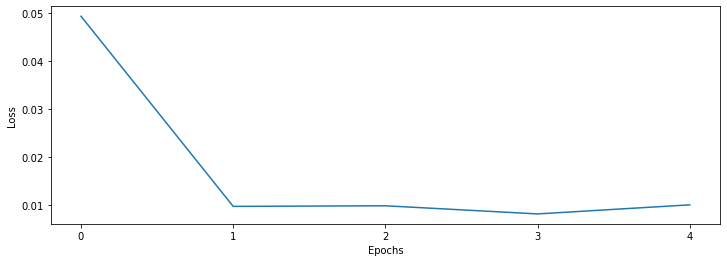

In [93]:
# Plotting loos of LSTM model
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [94]:
# Predictions
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [95]:
lstm_predictions_scaled

[array([0.8791059], dtype=float32),
 array([0.88243896], dtype=float32),
 array([0.8856497], dtype=float32),
 array([0.8868749], dtype=float32),
 array([0.8881834], dtype=float32),
 array([0.8893159], dtype=float32),
 array([0.8910133], dtype=float32),
 array([0.8915282], dtype=float32),
 array([0.89133054], dtype=float32),
 array([0.8914201], dtype=float32),
 array([0.8916102], dtype=float32),
 array([0.892308], dtype=float32),
 array([0.8940603], dtype=float32),
 array([0.8968543], dtype=float32),
 array([0.9003934], dtype=float32),
 array([0.90187365], dtype=float32),
 array([0.90336186], dtype=float32),
 array([0.90524375], dtype=float32)]

In [96]:
# We scaled our data that’s why we have to inverse it to see true predictions.
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
lstm_predictions

array([[1443.75509965],
       [1446.90481502],
       [1449.93894863],
       [1451.09679389],
       [1452.33332711],
       [1453.40352851],
       [1455.00759143],
       [1455.49413878],
       [1455.30736047],
       [1455.39201903],
       [1455.57164389],
       [1456.23105693],
       [1457.88699645],
       [1460.52729595],
       [1463.87178797],
       [1465.27059752],
       [1466.67695481],
       [1468.4553479 ]])

In [97]:
# Insample forecasting
test_data['LSTM_Predictions'] = lstm_predictions
test_data

<ipython-input-97-d22f6337f82e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['LSTM_Predictions'] = lstm_predictions


,ridership,LSTM_Predictions
Month,,
1968-01-01,1429,1443.755100
1968-02-01,1440,1446.904815
1968-03-01,1414,1449.938949
1968-04-01,1424,1451.096794
1968-05-01,1408,1452.333327
1968-06-01,1337,1453.403529
1968-07-01,1258,1455.007591
1968-08-01,1214,1455.494139
1968-09-01,1326,1455.307360


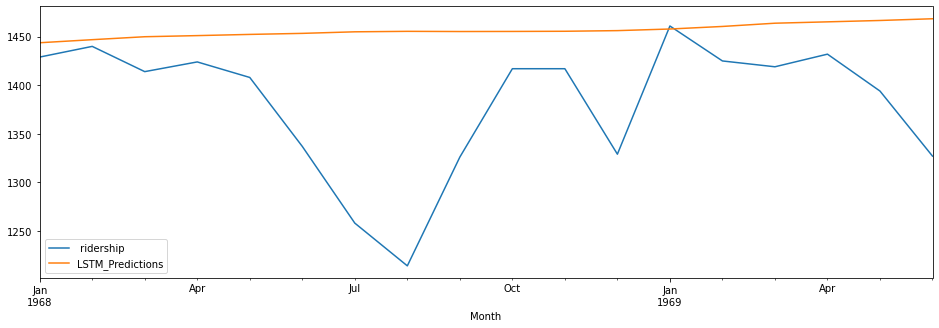

In [98]:
# Plotting actual and predicted_lstm values
test_data[' ridership'].plot(figsize = (16,5), legend=True)
test_data['LSTM_Predictions'].plot(legend = True);

#### Evaluation metrics

In [99]:
r2 = r2_score(test_data[' ridership'], test_data["LSTM_Predictions"])
lstm_rmse_error = rmse(test_data[' ridership'], test_data["LSTM_Predictions"])
lstm_mse_error = lstm_rmse_error**2
lstm_mae_error = mean_absolute_error(test_data[' ridership'], test_data["LSTM_Predictions"])
lstm_mape_error = np.mean(np.abs(test_data["LSTM_Predictions"] - test_data[' ridership'])/np.abs(test_data[' ridership']))*100 

In [100]:
# initialize list of lists
lstm_em_list = [[r2, lstm_mae_error, lstm_mse_error, lstm_rmse_error, lstm_mape_error]]

In [101]:
em3 = pd.DataFrame(lstm_em_list, columns=['r2_score','mean_absolute_error','mean_squared_error','root_mean_squared_error','mean_absolute_percentage_error'],index=['test_LSTM'])
em3

,r2_score,mean_absolute_error,mean_squared_error,root_mean_squared_error,mean_absolute_percentage_error
test_LSTM,-1.30856,74.908406,10027.30934,100.136454,5.677005


# SARIMA, Holt-Winter and LSTM Model Comparison 

### Actual and Predicted values of SARIMA, Holt-Winter and LSTM model

In [102]:
actual = test[' ridership']
data = {'Actual': actual, 'Predicted_SARIMA': test_predictions, 'Predicted_Holt-Winter': test_predictions_hw}
actual_predicted=pd.DataFrame(data)
actual_predicted['LSTM_Predictions'] = lstm_predictions
actual_predicted

,Actual,Predicted_SARIMA,Predicted_Holt-Winter,LSTM_Predictions
1968-01-01,1429,1442.098560,1457.095861,1443.755100
1968-02-01,1440,1473.594647,1474.638968,1446.904815
1968-03-01,1414,1440.164421,1438.373962,1449.938949
1968-04-01,1424,1464.636394,1467.119784,1451.096794
1968-05-01,1408,1436.914210,1442.651071,1452.333327
1968-06-01,1337,1414.916571,1417.993356,1453.403529
1968-07-01,1258,1377.864337,1393.391421,1455.007591
1968-08-01,1214,1336.591054,1363.897966,1455.494139
1968-09-01,1326,1442.874008,1445.697029,1455.307360
1968-10-01,1417,1474.746560,1502.715776,1455.392019


### Plot of Actual and Predicted values of SARIMA, Holt-Winter and LSTM model

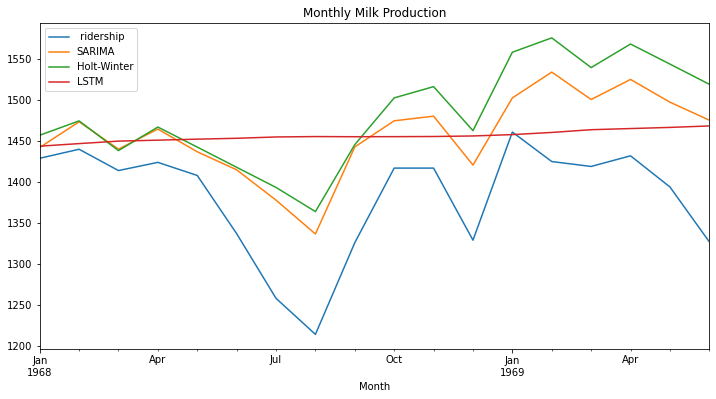

In [103]:
# Plot predictions against known values
title = 'Monthly Ridership'
ax = test[' ridership'].plot(legend=True,figsize=(12,6),title=title)
test_predictions.plot(legend=True, label='SARIMA')
test_predictions_hw.plot(legend=True,label='Holt-Winter')
test_data['LSTM_Predictions'].plot(legend = True,label='LSTM');
ax.autoscale(axis='x',tight=True)

- From this plot we can visualze that LSTM model is not good fit for forecasting the time series data.

### Evaluation metrics for SARIMA, Holt-Winter and LSTM model

In [104]:
em4 = pd.concat([em1,em2,em3])
em4

,r2_score,mean_absolute_error,mean_squared_error,root_mean_squared_error,mean_absolute_percentage_error
test_sarima,-0.677729,76.133423,7287.274902,85.365537,5.618362
train_sarima,0.914187,35.176693,6038.851557,77.710048,3.741010
test_holt-winter,-1.909161,100.986616,12636.041023,112.410146,7.414968
train_holt-winter,0.987424,23.891790,885.000519,29.748958,2.281549
test_LSTM,-1.308560,74.908406,10027.309340,100.136454,5.677005


In [105]:
# Getting index as a column of dataframe
em4['index'] = em4.index
em4

,r2_score,mean_absolute_error,mean_squared_error,root_mean_squared_error,mean_absolute_percentage_error,index
test_sarima,-0.677729,76.133423,7287.274902,85.365537,5.618362,test_sarima
train_sarima,0.914187,35.176693,6038.851557,77.710048,3.741010,train_sarima
test_holt-winter,-1.909161,100.986616,12636.041023,112.410146,7.414968,test_holt-winter
train_holt-winter,0.987424,23.891790,885.000519,29.748958,2.281549,train_holt-winter
test_LSTM,-1.308560,74.908406,10027.309340,100.136454,5.677005,test_LSTM


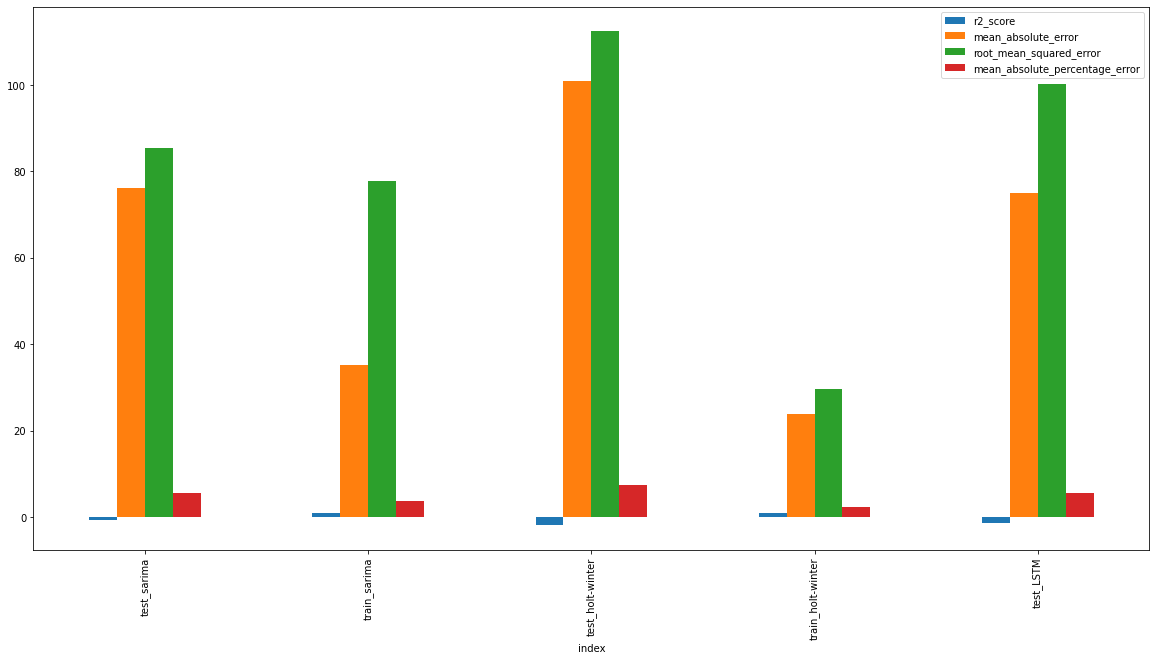

In [106]:
# plot the dataframe
em4.plot(x='index', y=["r2_score", "mean_absolute_error", "root_mean_squared_error", "mean_absolute_percentage_error"], kind="bar", figsize=(20, 10))
 
# print bar graph
plt.show()

- So, from this graph we can tell that the SARIMA is a better model with less mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error values and with greater r2_score values than Holt-Winter's and LSTM.
- Let's forecast the next 5 years means next 60 months values using SARIMA model.

## Outsample Forecasting using the best model (SARIMA)

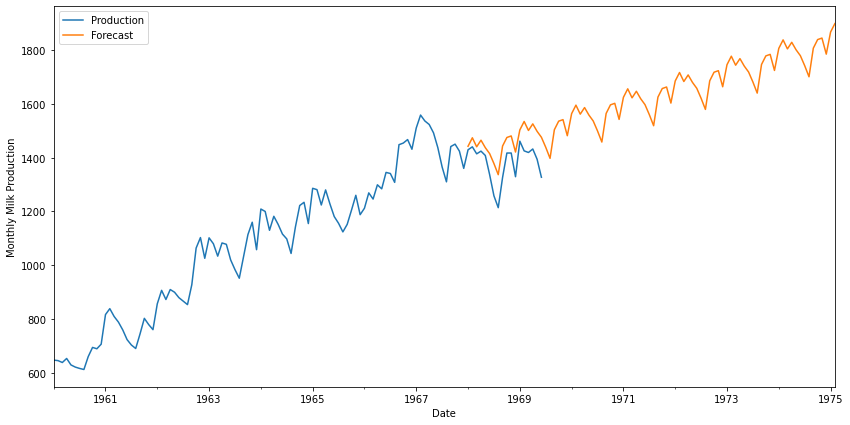

In [107]:
# Outsample forecast
pred_f = results.forecast(steps=86)
ax = df[' ridership'].plot(label='Production', figsize=(14, 7))
pred_f.plot(ax=ax, label='Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Monthly Ridership')
plt.legend()
plt.show()

In [108]:
pd.DataFrame(pred_f.iloc[18:])

,predicted_mean
1969-07-01,1438.461946
1969-08-01,1397.188664
1969-09-01,1503.471618
1969-10-01,1535.344169
1969-11-01,1540.990424
...,...
1974-10-01,1838.332215
1974-11-01,1843.978470
1974-12-01,1784.285673
1975-01-01,1866.279330


- Finally we have forecasted using SARIMA exponential smoothing for the next 5 years ridership monthly wise in India.

# Conclusion
 - Forecasting is a more important problem in the fields of business and industry, economics, medicine, finance and it's used for planning and decision making. In this study, we have computed the ridership monthly wise in India. The predicted values are nearest to the actual values and some of the forecasting values are the more nearest to the actual values.
 - The model verified with the available observed data with the forecasted from 1960 to 1969, the available observed value is almost nearest to the forecasted value for exponential smoothing. The advantage of SARIMA method given better accuracy in RMSE, MAPE, MAE, MSE, r2 score comparing with SARIMA and LSTM. 
 - This model forecasted production revealed an increase in the ridership in the future years. Hence, increase in the area of production and their sale in the suitable markets can be planned suitably. Hence the method used is SARIMA to forecast the future values.